# Project: DCT algorithm of image compression

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

# Sequential implementation

#### Calculation of the DCT matrix:
\begin{equation}
    \begin{matrix}
    T_{ij} & =
    & \left\{
    \begin{matrix}
    \frac{1}{\sqrt N} & \mbox{if } i = 0 \\
    \sqrt \frac {2}{N} \cos \frac{(2j + 1)i \pi}{2N} & \mbox{if } i > 0
    \end{matrix} \right.
    \end{matrix}
\end{equation}

In [5]:
def dct_matrix(N = 8):
    t = np.empty((N, N), dtype = np.float64)
    for i in range(N):
        for j in range(N):
            if i == 0:
                t[i][j] = 1 / np.sqrt(N)
            else:
                t[i][j] = np.sqrt(2 / N) * np.cos((2 * j + 1) * i * np.pi / (2 * N))
            t[i][j] = np.round(t[i][j], 4)
            
    return t

#### Calculation of the quantization matrix

In [6]:
def quantization_matrix(quality_level = 50, N = 8):
    Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
              [12, 12, 14, 19, 26, 58, 60, 55], 
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])
    if quality_level == 50:
        return Q
    elif quality_level < 50:
        Q *= 50 / quality_level
    else:
        Q *= (100 - quality_level) / 50
    
    Q = np.where(Q > 255, 255, Q)
    return Q

#### Compression process:
\begin{equation}
    D = TMT^T
\end{equation}

\begin{equation}
    C_{ij} = round(\frac{D_{ij}}{Q_{ij}})
\end{equation}

In [7]:
def compression(arr, t, Q, N = 8):
    height = arr.shape[0]
    width = arr.shape[1]
    result = np.empty(arr.shape)
    
    for i in range(0, height - N + 1, N):
        for j in range(0, width - N + 1, N):
            temp = arr[i:(i + N), j:(j + N)]
            D = np.round(t @ temp @ t.T, 4)
            C = np.round(D / Q).astype(int)
            result[i:(i + N), j:(j + N)] = C
            
    return result

#### Decompression process:
\begin{equation}
    R_{ij} = Q_{ij} \times C_{ij}
\end{equation}

\begin{equation}
    N = round(T^TRT) + 128
\end{equation}

In [8]:
def decompression(arr, t, Q, N = 8):
    height = arr.shape[0]
    width = arr.shape[1]
    res_rec = np.empty(arr.shape, dtype = int)

    for i in range(0, height - N + 1, N):
        for j in range(0, width - N + 1, N):
            temp = arr[i:(i + N), j:(j + N)]
            R = np.multiply(Q, temp)
            reconstructed = np.round(t.T @ R @ t).astype(int) + 128      
            res_rec[i:(i + N), j:(j + N)] = reconstructed
            
    return res_rec

#### Main call

In [39]:
init_image = cv2.imread('lion_3.jpg')

YCrCb_image = cv2.cvtColor(init_image, cv2.COLOR_BGR2YCR_CB)
Y = np.array(YCrCb_image[:, :, 0]).astype(int)
Cr = np.array(YCrCb_image[:, :, 1]).astype(int)
Cb = np.array(YCrCb_image[:, :, 2]).astype(int)
Y, Cr, Cb = Y - 128, Cr - 128, Cb - 128

t = dct_matrix()
Q = quantization_matrix()

time_start = time.time()

Y_compressed = compression(Y, t, Q)
Cr_compressed = compression(Cr, t, Q)
Cb_compressed = compression(Cb, t, Q)

Y_decomposed = decompression(Y_compressed, t, Q)
Y_decomposed = np.where(Y_decomposed > 255, 255, Y_decomposed)
Cr_decomposed = decompression(Cr_compressed, t, Q)
Cr_decomposed = np.where(Cr_decomposed > 255, 255, Cr_decomposed)
Cb_decomposed = decompression(Cb_compressed, t, Q)
Cb_decomposed = np.where(Cb_decomposed > 255, 255, Cb_decomposed)

YCrCb_decomposed = np.stack((Y_decomposed, Cr_decomposed, Cb_decomposed), axis = 2)
RGB_image = cv2.cvtColor(YCrCb_decomposed.astype(np.uint8), cv2.COLOR_YCR_CB2BGR)

time_seq = time.time() - time_start
print(f'Working time of a sequential program is {time_seq:.4f} s')

cv2.imwrite('sequential.jpg', RGB_image)

Working time of a sequential program is 0.6895 s


True

### Comparison of images' weights

In [29]:
import os

weight_init = os.path.getsize('lion_3.jpg')
weight_compressed = os.path.getsize('sequential.jpg')

print(f'Initial weight is {weight_init / 1024:.0f} kB\n')
print(f'Weight after compression is {weight_compressed / 1024:.0f} kB\n')
print(f'Initial image is {weight_init / weight_compressed:.3f} heavier')

Initial weight is 150 kB

Weight after compression is 142 kB

Initial image is 1.051 heavier


### Plotting two images

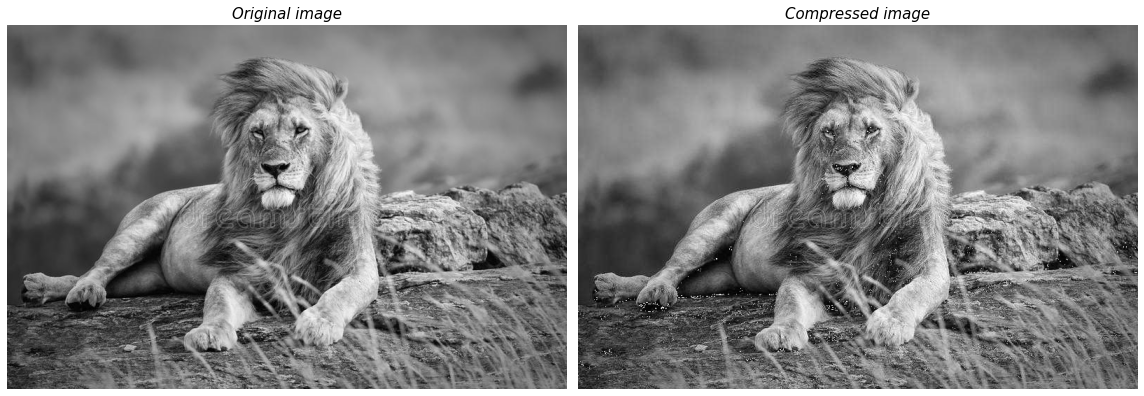

In [11]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(16, 20))

ax.imshow(init_image)
ax.set_title('Original image', fontsize = 15, fontstyle = 'oblique')
ax.set_axis_off()

bx.imshow(RGB_image)
bx.set_title('Compressed image', fontsize = 15, fontstyle = 'oblique')
bx.set_axis_off()

fig.tight_layout()
plt.show()

# Parallel implementation

In [33]:
%%writefile parallel.py

import numpy as np
from mpi4py import MPI
import cv2
import time

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

def dct_matrix(N = 8):
    t = np.empty((N, N), dtype = np.float64)
    for i in range(N):
        for j in range(N):
            if i == 0:
                t[i][j] = 1 / np.sqrt(N)
            else:
                t[i][j] = np.sqrt(2 / N) * np.cos((2 * j + 1) * i * np.pi / (2 * N))
            t[i][j] = np.round(t[i][j], 4)
            
    return t

def quantization_matrix(quality_level = 50, N = 8):
    Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
              [12, 12, 14, 19, 26, 58, 60, 55], 
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])
    if quality_level == 50:
        return Q
    elif quality_level < 50:
        Q *= 50 / quality_level
    else:
        Q *= (100 - quality_level) / 50
    
    Q = np.where(Q > 255, 255, Q)
    return Q

def compression(arr, t, Q, N = 8):
    height = arr.shape[0]
    width = arr.shape[1]
    result = np.empty(arr.shape)
    
    for i in range(0, height - N + 1, N):
        for j in range(0, width - N + 1, N):
            temp = arr[i:(i + N), j:(j + N)]
            D = np.round(t @ temp @ t.T, 4)
            C = np.round(D / Q).astype(int)
            result[i:(i + N), j:(j + N)] = C
            
    return result

def decompression(arr, t, Q, N = 8):
    height = arr.shape[0]
    width = arr.shape[1]
    result = np.empty(arr.shape, dtype = int)

    for i in range(0, height - N + 1, N):
        for j in range(0, width - N + 1, N):
            temp = arr[i:(i + N), j:(j + N)]
            R = np.multiply(Q, temp)
            reconstructed = np.round(t.T @ R @ t).astype(int) + 128      
            result[i:(i + N), j:(j + N)] = reconstructed        
    return result

init_image = cv2.imread('lion_3.jpg')

t = dct_matrix()
Q = quantization_matrix()
N = 8

total_width = init_image.shape[1]

index = np.linspace(0, total_width, size+1, dtype = int)
image_rank = init_image[:, index[rank]:index[rank+1]]

YCrCb_image = cv2.cvtColor(image_rank, cv2.COLOR_BGR2YCR_CB)
Y = np.array(YCrCb_image[:, :, 0]).astype(int)
Cr = np.array(YCrCb_image[:, :, 1]).astype(int)
Cb = np.array(YCrCb_image[:, :, 2]).astype(int)
Y, Cr, Cb = Y - 128, Cr - 128, Cb - 128

time_start = time.time()

Y_compressed = compression(Y, t, Q)
Cr_compressed = compression(Cr, t, Q)
Cb_compressed = compression(Cb, t, Q)

Y_decomposed = decompression(Y_compressed, t, Q)
Y_decomposed = np.where(Y_decomposed > 255, 255, Y_decomposed)
Cr_decomposed = decompression(Cr_compressed, t, Q)
Cr_decomposed = np.where(Cr_decomposed > 255, 255, Cr_decomposed)
Cb_decomposed = decompression(Cb_compressed, t, Q)
Cb_decomposed = np.where(Cb_decomposed > 255, 255, Cb_decomposed)


YCrCb_decomposed = np.stack((Y_decomposed, Cr_decomposed, Cb_decomposed), axis = 2)
RGB_image = cv2.cvtColor(YCrCb_decomposed.astype(np.uint8), cv2.COLOR_YCR_CB2BGR)

data = comm.gather(RGB_image, root = 0)
   
if rank == 0:
    value = np.concatenate(tuple(data), axis = 1)   
    cv2.imwrite('parallel.jpg', value)
    
    work_time = time.time() - time_start
    print(work_time)

Overwriting parallel.py


In [38]:
time_parallel = !mpiexec -np 5 python parallel.py
print(f"Working time of a parallel program is {time_parallel[0][:6]} s")

Working time of a parallel program is 0.2957 s


# Implementation with Numba

In [1]:
from numba import njit

In [2]:
def dct_matrix(N = 8):
    t = np.empty((N, N), dtype = np.float64)
    for i in range(N):
        for j in range(N):
            if i == 0:
                t[i][j] = 1 / np.sqrt(N)
            else:
                t[i][j] = np.sqrt(2 / N) * np.cos((2 * j + 1) * i * np.pi / (2 * N))
            t[i][j] = np.round(t[i][j], 4)
            
    return t

def quantization_matrix(quality_level = 50, N = 8):
    Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
              [12, 12, 14, 19, 26, 58, 60, 55], 
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]], dtype = np.float64)
    if quality_level == 50:
        return Q
    elif quality_level < 50:
        Q *= 50 / quality_level
    else:
        Q *= (100 - quality_level) / 50
    
    Q = np.where(Q > 255, 255, Q)
    return Q

@njit(cache = True)
def compression_numba(t, Q, arr = None, N = 8):
    height = arr.shape[0]
    width = arr.shape[1]
    result = np.empty(arr.shape)
    
    for i in range(0, height - N + 1, N):
        for j in range(0, width - N + 1, N):
            temp = arr[i:(i + N), j:(j + N)].astype(np.float64)
            D = np.empty_like(temp)
            np.round(t @ temp @ t.T, 4, D)
            C = np.empty_like(temp)
            np.round(D / Q, 0, C)
            C = C.astype(np.int64)
            result[i:(i + N), j:(j + N)] = C
            
    return result

@njit(cache = True)
def decompression_numba(t, Q, arr = None, N = 8):
    height = arr.shape[0]
    width = arr.shape[1]
    result = np.empty(arr.shape, dtype = np.int64)

    for i in range(0, height - N + 1, N):
        for j in range(0, width - N + 1, N):
            temp = arr[i:(i + N), j:(j + N)]
            R = np.multiply(Q, temp)
            reconstructed = np.empty_like(temp)
            np.round(t.T @ R @ t, 0, reconstructed)
            reconstructed = reconstructed.astype(np.int64) + 128      
            result[i:(i + N), j:(j + N)] = reconstructed        
    return result

In [6]:
init_image = cv2.imread('lion_3.jpg')

YCrCb_image = cv2.cvtColor(init_image, cv2.COLOR_BGR2YCR_CB)
Y = np.array(YCrCb_image[:, :, 0]).astype(np.int64)
Cr = np.array(YCrCb_image[:, :, 1]).astype(np.int64)
Cb = np.array(YCrCb_image[:, :, 2]).astype(np.int64)
Y, Cr, Cb = Y - 128, Cr - 128, Cb - 128

t = dct_matrix()
Q = quantization_matrix()

Y_compressed = compression_numba(t, Q, Y)
Y_decomposed = decompression_numba(t, Q, Y_compressed)

time_start = time.time()

Y_compressed = compression_numba(t, Q, Y)
Cr_compressed = compression_numba(t, Q, Cr)
Cb_compressed = compression_numba(t, Q, Cb)

Y_decomposed = decompression_numba(t, Q, Y_compressed)
Y_decomposed = np.where(Y_decomposed > 255, 255, Y_decomposed)
Cr_decomposed = decompression_numba(t, Q, Cr_compressed)
Cr_decomposed = np.where(Cr_decomposed > 255, 255, Cr_decomposed)
Cb_decomposed = decompression_numba(t, Q, Cb_compressed)
Cb_decomposed = np.where(Cb_decomposed > 255, 255, Cb_decomposed)

YCrCb_decomposed = np.stack((Y_decomposed, Cr_decomposed, Cb_decomposed), axis = 2)
RGB_image = cv2.cvtColor(YCrCb_decomposed.astype(np.uint8), cv2.COLOR_YCR_CB2BGR)

time_numba = time.time() - time_start

print(f"Working time of a program with Numba is {time_numba:.4f} s")

Working time of a program with Numba is 0.0709 s
